In [1]:
%%capture
%load_ext autoreload
%autoreload 2
#Basic Imports
import os,sys
os.chdir("..")

from tqdm import tqdm,trange
import numpy as np
from sklearn.metrics import classification_report
import torch

from datasets.ssl_dataset import SSL_Dataset
from datasets.data_utils import get_data_loader
from utils import get_model_checkpoints
from utils import net_builder
from utils import clean_results_df
from utils import get_model_checkpoints

import pandas as pd
from termcolor import colored
from copy import deepcopy

## 1) - Set noise parameters

In [2]:
P_noise_dB_min = 0 #[dB], Noise power in dB
P_noise_dB_max = 27 #[dB], Max Noise power in dB 
dP_noise_dB = 3 # [dB], Delta power in dB

## 2) - Initialize parameters

In [11]:
#Path to the runs to load
csv_folder = "/home/gabrielemeoni/project/SSLRS"
dataset = "eurosat_rgb"
folder = "/scratch/fixmatch_results/new_runs/nr_of_labels"#"/scratch/fixmatch_results/new_runs/nr_of_labels/eurosat_rgb/"
sort_criterion = "numlabels" # Accepted net, numlabels
seed_wanted = 0 # Seed wanted (the others will be filtered)

In [12]:
folder=os.path.join(folder, dataset)
checkpoints, run_args = get_model_checkpoints(folder)
if os.name == 'nt':
       [print(_.split("\\")[1]) for _ in checkpoints];
else:
       [print(_.split("/")[1]) for _ in checkpoints];

scratch
scratch
scratch
scratch
scratch
scratch
scratch
scratch
scratch
scratch


## 3) - Evaluate all test data

In [13]:
results = []
for checkpoint, args in zip(checkpoints,run_args):
    print("------------ RUNNING ", checkpoint, " -----------------")
    print(args)
    args["batch_size"] = 256
    args["data_dir"] = "./data/"
    args["use_train_model"] = False
    args["load_path"] = checkpoint
    
    if args["seed"] == seed_wanted:
        checkpoint_path = os.path.join(args["load_path"])
        checkpoint = torch.load(checkpoint_path,map_location='cuda:0')
        load_model = (checkpoint["train_model"] if args["use_train_model"] else checkpoint["eval_model"])
        _net_builder = net_builder(args["net"],False,{})
        _eval_dset = SSL_Dataset(name=args["dataset"], train=False, data_dir=args["data_dir"], seed=args["seed"])
        eval_dset = _eval_dset.get_dset()
        inv_transf = _eval_dset.inv_transform
        transf = _eval_dset.transform
        net = _net_builder(num_classes=_eval_dset.num_classes, in_channels=_eval_dset.num_channels)
        net.load_state_dict(load_model)
        if torch.cuda.is_available():
            net.cuda()
        net.eval()
                        
        eval_loader = get_data_loader(eval_dset, args["batch"], num_workers=1)
        label_encoding = _eval_dset.label_encoding
        dB_value_list = []
        resuts_run = []
        
        for P_noise_dB in range(P_noise_dB_min, P_noise_dB_max, dP_noise_dB):
            print("------------ PREDICTING TESTSET ----------------- - Noise value [dB]", P_noise_dB)
            
            
            images, labels, preds = [],[],[]
            with torch.no_grad():
                for image, target in tqdm(eval_loader):
                    image_preprocessed=[]
                    for idx,img in enumerate(image):
                        img=255 * inv_transf(img.transpose(0,2).cpu().numpy())
                        img_orig=img
                        for n in range(img.shape[0]):
                            img[n]=(0.75 + 0.5 * torch.rand(size=(1,))) * img[n]
                        
                        A_noise = (10**(P_noise_dB/20))
                        noise=torch.randn(size=img.shape) * A_noise
                        img+= noise
                        
                        image[idx] = transf(1/255*torch.clip(img, 0, 255).transpose(0,2).cpu().numpy())
                            
                    logit = net(image.cuda())
                    preds.append(logit.cpu().max(1)[1])
                    labels.append(target)
            labels = torch.cat(labels).numpy()
            preds = torch.cat(preds).numpy()
            test_report = classification_report(labels, preds, target_names=label_encoding, output_dict=True)
            test_report["params"] = args
            dB_value_list.append("P_noise_"+str(P_noise_dB)+"_dB")
            resuts_run.append(test_report)
        results_noise_dict = dict(zip(dB_value_list, resuts_run))
        results.append(results_noise_dict)

  0%|          | 0/10 [00:00<?, ?it/s]

------------ RUNNING  /scratch/fixmatch_results/new_runs/nr_of_labels/eurosat_rgb/FixMatch_archefficientnet-b2_batch32_confidence0.95_lr0.03_uratio7_wd0.00075_wu1.0_seed0_numlabels500_optSGD/model_best.pth  -----------------
{'dataset': 'eurosat_rgb', 'net': 'efficientnet-b2', 'batch': 32, 'confidence': 0.95, 'lr': 0.03, 'uratio': 7, 'wd': 0.00075, 'wu': 1.0, 'seed': 0, 'numlabels': 500, 'opt': 'SGD', 'iterations': 461000}
Using not pretrained model efficientnet-b2 ...


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 0


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 3


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 6


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 9


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 12


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 15


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 18


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 21


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 24


  0%|          | 0/10 [00:00<?, ?it/s]

------------ RUNNING  /scratch/fixmatch_results/new_runs/nr_of_labels/eurosat_rgb/FixMatch_archefficientnet-b2_batch32_confidence0.95_lr0.03_uratio7_wd0.00075_wu1.0_seed0_numlabels3000_optSGD/model_best.pth  -----------------
{'dataset': 'eurosat_rgb', 'net': 'efficientnet-b2', 'batch': 32, 'confidence': 0.95, 'lr': 0.03, 'uratio': 7, 'wd': 0.00075, 'wu': 1.0, 'seed': 0, 'numlabels': 3000, 'opt': 'SGD', 'iterations': 495000}
Using not pretrained model efficientnet-b2 ...


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 0


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 3


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 6


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 9


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 12


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 15


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 18


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 21


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 24


  0%|          | 0/10 [00:00<?, ?it/s]

------------ RUNNING  /scratch/fixmatch_results/new_runs/nr_of_labels/eurosat_rgb/FixMatch_archefficientnet-b2_batch32_confidence0.95_lr0.03_uratio7_wd0.00075_wu1.0_seed0_numlabels100_optSGD/model_best.pth  -----------------
{'dataset': 'eurosat_rgb', 'net': 'efficientnet-b2', 'batch': 32, 'confidence': 0.95, 'lr': 0.03, 'uratio': 7, 'wd': 0.00075, 'wu': 1.0, 'seed': 0, 'numlabels': 100, 'opt': 'SGD', 'iterations': 493000}
Using not pretrained model efficientnet-b2 ...


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 0


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 3


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 6


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 9


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 12


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 15


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 18


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 21


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 24


  0%|          | 0/10 [00:00<?, ?it/s]

------------ RUNNING  /scratch/fixmatch_results/new_runs/nr_of_labels/eurosat_rgb/FixMatch_archefficientnet-b2_batch32_confidence0.95_lr0.03_uratio7_wd0.00075_wu1.0_seed3_numlabels100_optSGD/model_best.pth  -----------------
{'dataset': 'eurosat_rgb', 'net': 'efficientnet-b2', 'batch': 32, 'confidence': 0.95, 'lr': 0.03, 'uratio': 7, 'wd': 0.00075, 'wu': 1.0, 'seed': 3, 'numlabels': 100, 'opt': 'SGD', 'iterations': 0}
------------ RUNNING  /scratch/fixmatch_results/new_runs/nr_of_labels/eurosat_rgb/FixMatch_archefficientnet-b2_batch32_confidence0.95_lr0.03_uratio7_wd0.00075_wu1.0_seed3_numlabels500_optSGD/model_best.pth  -----------------
{'dataset': 'eurosat_rgb', 'net': 'efficientnet-b2', 'batch': 32, 'confidence': 0.95, 'lr': 0.03, 'uratio': 7, 'wd': 0.00075, 'wu': 1.0, 'seed': 3, 'numlabels': 500, 'opt': 'SGD', 'iterations': 0}
------------ RUNNING  /scratch/fixmatch_results/new_runs/nr_of_labels/eurosat_rgb/FixMatch_archefficientnet-b2_batch32_confidence0.95_lr0.03_uratio7_wd0.000

  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 0


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 3


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 6


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 9


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 12


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 15


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 18


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 21


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 24


  0%|          | 0/10 [00:00<?, ?it/s]

------------ RUNNING  /scratch/fixmatch_results/new_runs/nr_of_labels/eurosat_rgb/FixMatch_archefficientnet-b2_batch32_confidence0.95_lr0.03_uratio7_wd0.00075_wu1.0_seed4_numlabels100_optSGD/model_best.pth  -----------------
{'dataset': 'eurosat_rgb', 'net': 'efficientnet-b2', 'batch': 32, 'confidence': 0.95, 'lr': 0.03, 'uratio': 7, 'wd': 0.00075, 'wu': 1.0, 'seed': 4, 'numlabels': 100, 'opt': 'SGD', 'iterations': 0}
------------ RUNNING  /scratch/fixmatch_results/new_runs/nr_of_labels/eurosat_rgb/FixMatch_archefficientnet-b2_batch32_confidence0.95_lr0.03_uratio7_wd0.00075_wu1.0_seed0_numlabels1000_optSGD/model_best.pth  -----------------
{'dataset': 'eurosat_rgb', 'net': 'efficientnet-b2', 'batch': 32, 'confidence': 0.95, 'lr': 0.03, 'uratio': 7, 'wd': 0.00075, 'wu': 1.0, 'seed': 0, 'numlabels': 1000, 'opt': 'SGD', 'iterations': 478000}
Using not pretrained model efficientnet-b2 ...


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 0


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 3


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 6


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 9


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 12


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 15


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 18


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 21


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 24


100%|██████████| 85/85 [00:05<00:00, 15.84it/s]


------------ RUNNING  /scratch/fixmatch_results/new_runs/nr_of_labels/eurosat_rgb/FixMatch_archefficientnet-b2_batch32_confidence0.95_lr0.03_uratio7_wd0.00075_wu1.0_seed0_numlabels50_optSGD/model_best.pth  -----------------
{'dataset': 'eurosat_rgb', 'net': 'efficientnet-b2', 'batch': 32, 'confidence': 0.95, 'lr': 0.03, 'uratio': 7, 'wd': 0.00075, 'wu': 1.0, 'seed': 0, 'numlabels': 50, 'opt': 'SGD', 'iterations': 450000}


  0%|          | 0/10 [00:00<?, ?it/s]

Using not pretrained model efficientnet-b2 ...


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 0


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 3


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 6


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 9


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 12


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 15


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 18


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 21


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 24


100%|██████████| 85/85 [00:05<00:00, 16.10it/s]

------------ RUNNING  /scratch/fixmatch_results/new_runs/nr_of_labels/eurosat_rgb/FixMatch_archefficientnet-b0_batch32_confidence0.95_lr0.03_uratio7_wd0.00075_wu1.0_seed4_numlabels100_optSGD/model_best.pth  -----------------
{'dataset': 'eurosat_rgb', 'net': 'efficientnet-b0', 'batch': 32, 'confidence': 0.95, 'lr': 0.03, 'uratio': 7, 'wd': 0.00075, 'wu': 1.0, 'seed': 4, 'numlabels': 100, 'opt': 'SGD', 'iterations': 0}


## 4) - Creating a PANDAS dataframe and export it to CSV file

In [15]:
big_df = pd.DataFrame()
pd.set_option('display.max_columns', None)
for result in results:
    df = pd.DataFrame()
    for dB_value in dB_value_list:
        if dB_value == dB_value_list[0]:
            result_0_dB = result[dB_value_list[0]]
            params = result_0_dB["params"]
            df_local = pd.DataFrame(result_0_dB)
            df_local.drop(list(params.keys()),inplace=True)
            accuracy_0_dB = result_0_dB['accuracy']
            df_local.drop(["support","recall","precision"],inplace=True)
            df_local.drop('accuracy',axis=1 ,inplace=True)
            
            for key,val in params.items():
                df_local[key] = val
                
            df_local = df_local.set_index("dataset")
            df_local.insert(len(df_local.columns), 'accuracy - [0dB]', accuracy_0_dB)
            #df_local = df_local.rename(columns={'accuracy': 'accuracy - [0dB]'})
            
            df=df_local
        else:
            results_n_dB = result[dB_value]
            df.insert(len(df.columns), 'accuracy - ['+dB_value.replace("P_noise_","").replace("_dB","")+"dB]", results_n_dB["accuracy"])

    big_df = big_df.append(df)


small_df = clean_results_df(big_df, folder,sort_criterion, swap_accuracy_position=False)
print(small_df)
small_df.to_csv(os.path.join(csv_folder , "noise_test_results_"+str(dataset)+"_seed_"+str(seed_wanted)+".csv"))
print("CSV file saved:", os.path.join(csv_folder , "noise_test_results_"+str(dataset)+"_seed_"+str(seed_wanted)+".csv"))

                         net pretrained supervised  batch  confidence    lr  \
dataset                                                                       
eurosat_rgb  efficientnet-b2      False      False     32        0.95  0.03   
eurosat_rgb  efficientnet-b2      False      False     32        0.95  0.03   
eurosat_rgb  efficientnet-b2      False      False     32        0.95  0.03   
eurosat_rgb  efficientnet-b2      False      False     32        0.95  0.03   
eurosat_rgb  efficientnet-b2      False      False     32        0.95  0.03   
eurosat_rgb  efficientnet-b2      False      False     32        0.95  0.03   

             uratio       wd   wu  numlabels  opt  iterations  \
dataset                                                         
eurosat_rgb       7  0.00075  1.0         50  SGD      450000   
eurosat_rgb       7  0.00075  1.0        100  SGD      493000   
eurosat_rgb       7  0.00075  1.0        500  SGD      461000   
eurosat_rgb       7  0.00075  1.0       10

## 5) - Creating plots

Run **only** once you have extracted all the *csv* files for all the 0,1,2 seeds.

In [28]:
accuracy_noise=[]
for seed in [0,1,2]:
    csv_file=os.path.join(csv_folder, "noise_test_results"+"_seed_"+str(seed)+".csv")
    df_seed = pd.read_csv(csv_file)
    accuracy_noise_seed=[]
    for dB_value in dB_value_list:
        accuracy_noise_seed.append(df_seed['accuracy - ['+dB_value.replace("P_noise_","").replace("_dB","")+"dB]"])
    
    if len(accuracy_noise) == 0:
        for n in accuracy_noise_seed:
            accuracy_noise.append(n/3*100)
    else:
        for n in range(len(accuracy_noise_seed)):
            for m in range(len(accuracy_noise_seed[0])):
                accuracy_noise[n][m]+=accuracy_noise_seed[n][m]/3*100

        

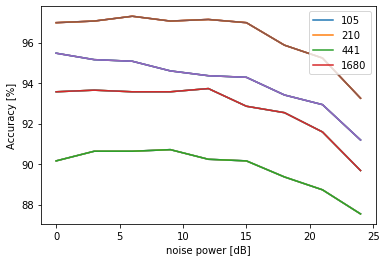

In [32]:
import matplotlib.pyplot as plt

for numlabels in small_df["numlabels"]:
    acc_numlabels=small_df.loc[small_df["numlabels"] == numlabels]
    
    plt.plot(np.arange(P_noise_dB_min, P_noise_dB_max, dP_noise_dB), accuracy_noise)
    

plt.legend(small_df["numlabels"])
plt.xlabel('noise power [dB]')
plt.ylabel('Accuracy [%]') 
plt.savefig("noise_graph_"+dataset+".png")